In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imageio


In [3]:
df = pd.read_pickle('nominator_data_full.pkl')

In [ ]:
df.columns

In [5]:
df["amount"] = pd.to_numeric(df["amount"])
df["selfBonded"] = pd.to_numeric(df["selfBonded"])
df["totalBonded"] = pd.to_numeric(df["totalBonded"])

In [9]:
df['normalized_amount'] = df.groupby('era_id')['amount'].transform(lambda x: x / x.max())

# Determine the top K nominators across all eras
K = 1000
top_nominators = df.groupby('nominatorId')['amount'].sum().nlargest(K).index

# Get all validators
all_validators = df['validatorId'].unique()

# Restrict the data to the top K nominators and all validators
df = df[df['nominatorId'].isin(top_nominators)]

# Get the list of eras
eras = df['era_id'].unique()


# Create a directory for storing images if not exists
import os
if not os.path.exists('images'):
    os.makedirs('images')

# Create and save a heatmap for each era
for era in eras:
    # Get the data for the era
    df_era = df[df['era_id'] == era]
    
    # Create a pivot table
    pivot_table = df_era.pivot_table(values='normalized_amount', index='nominatorId', columns='validatorId', fill_value=0)
    
    # Adjust the pivot table to include all top nominators and validators, and fill missing values with 0
    pivot_table = pivot_table.reindex(index=top_nominators, columns=all_validators, fill_value=0)
    
    # Sort the pivot table to have a consistent order of nominators and validators
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    pivot_table = np.log1p(pivot_table)
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, cmap='viridis', vmin=0, vmax=0.0001)
    plt.title(f"Era {era}")
    
    # Save the heatmap as an image
    plt.savefig(f'images/heatmap_{era}.png')
    plt.close()

In [ ]:
# Create a video from images
images = [imageio.imread(f'images/heatmap_{era}.png') for era in eras]
imageio.mimsave('heatmap_video_sfast.gif', images, duration=0.4)

In [21]:
# Check sparsity by counting non-zero entries in the pivot_table
non_zero_count = np.count_nonzero(pivot_table.values)
total_values = pivot_table.size
sparsity = 1 - (non_zero_count / total_values)

print(f"Sparsity: {sparsity}")

Sparsity: 0.9993920883164673


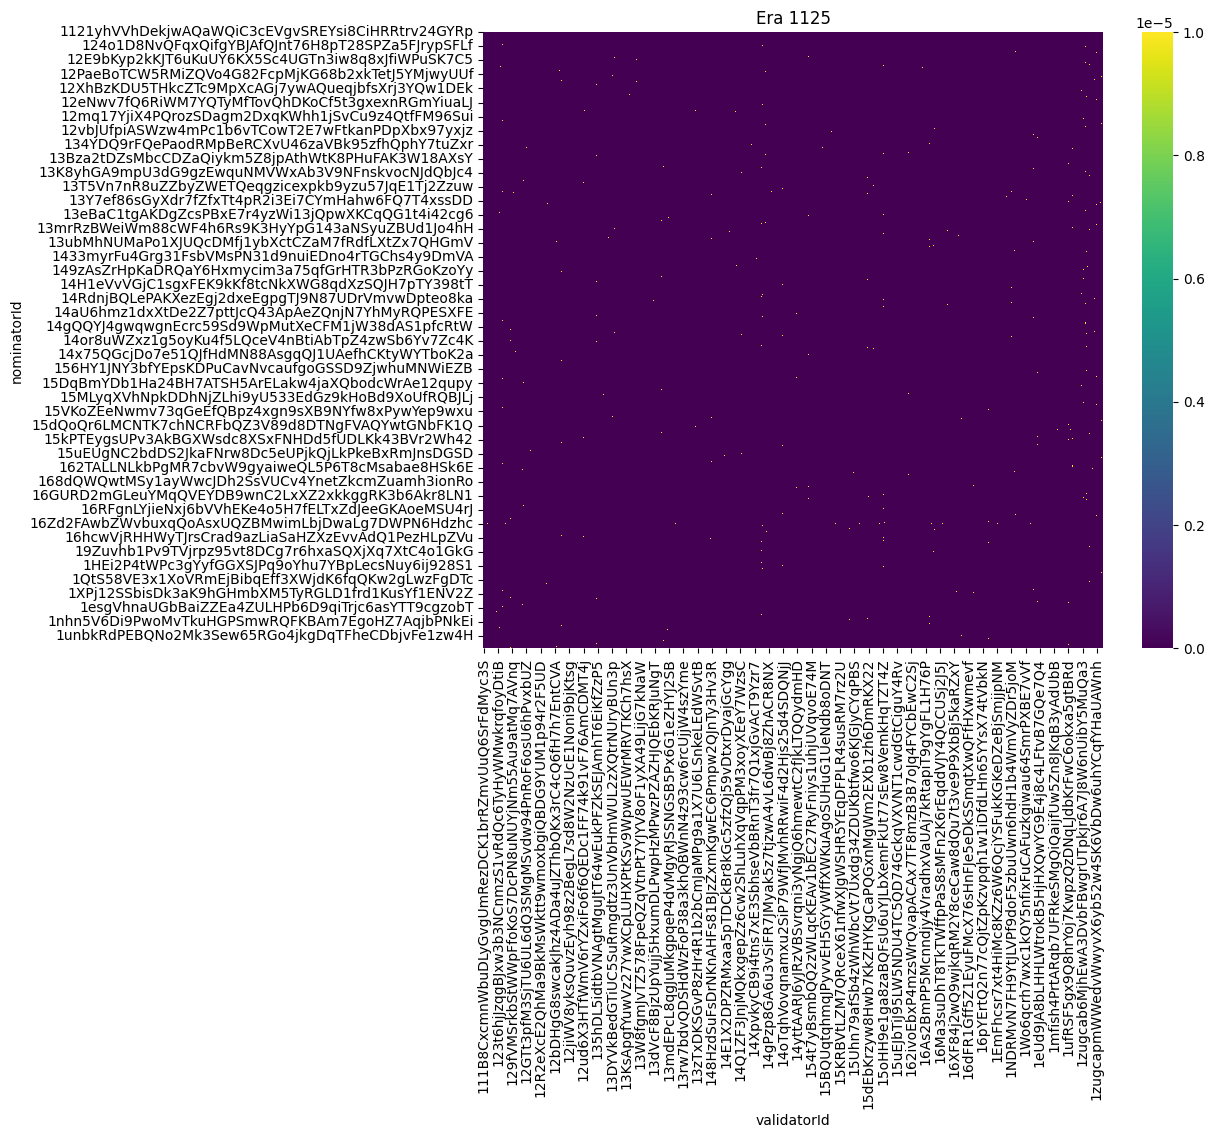

In [24]:
# Plot heatmap with a specified color scale range
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', vmin=0, vmax=0.001)
plt.title(f"Era {era}")
plt.show()

In [26]:
# Check some values in the pivot_table
print(pivot_table.values)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
# Check maximum and minimum non-zero values in the pivot_table
max_value = np.max(pivot_table.values[pivot_table.values > 0])
min_value = np.min(pivot_table.values[pivot_table.values > 0])

print(f"Max value: {max_value}")
print(f"Min value: {min_value}")


Max value: 1.0
Min value: 5.439590529899363e-06


In [28]:
pivot_table = np.log1p(pivot_table)  # log1p function applies log(1 + x), safe for zero values